# Test Data Analysis
Just messin around

In [1]:
# Install libraries
%pip install firebase_admin google-cloud-firestore pandas matplotlib


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
# Firebase setup

import firebase_admin
from firebase_admin import credentials, firestore

cred = credentials.Certificate("secrets/firebase_key.json")
firebase_admin.initialize_app(cred)

db = firestore.client()

In [7]:
# Get user data

import firebase_admin
from firebase_admin import auth

email = "alexxander1611@gmail.com"

user = auth.get_user_by_email(email)
print(f'Successfully fetched user data: {user.uid}')

user_info = db.collection('Users').document(user.uid).get().to_dict()
print(user_info)


Successfully fetched user data: hiZJsylQKJNitULApBf4e9XH9vg1


E0000 00:00:1760566059.276841 12789726 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


{'uid': 'hiZJsylQKJNitULApBf4e9XH9vg1', 'email': 'Alexxander1611@gmail.com'}


In [8]:
# Fetch IMU data

import pandas as pd

imu_coll = db.collection('UserIMU').document(user.uid).collection('Sessions')
query = imu_coll.order_by("time", direction=firestore.Query.DESCENDING).limit(1)
user_imu = query.get()[0].to_dict()

rows = []

for device, device_data in user_imu['data'].items():
	for imu_function,data in device_data.items():
		segmentIdx = 0
		for segment in data.values():
			for entry in segment:
				for simd in entry['list']:
					entry = {}
					entry["Device"] = device
					entry['Type'] = imu_function 
					entry['Time'] = simd['readTime']
					entry['Segment'] = segmentIdx
					entry["X"] = simd['read'][0]
					entry["Y"] = simd['read'][1]
					entry["Z"] = simd['read'][2]
					entry['Timestamp'] = user_imu['time']
					rows.append(entry)
			segmentIdx += 1
df = pd.DataFrame(rows)
df

,Device,Type,Time,Segment,X,Y,Z,Timestamp
0,Kappa,mag,1.760566e+09,0,-2.599622,-1.605562,0.696910,1.760566e+09
1,Kappa,mag,1.760566e+09,0,-2.514076,-1.454732,0.724595,1.760566e+09
2,Kappa,mag,1.760566e+09,0,-2.590394,-1.465230,0.723033,1.760566e+09
3,Kappa,mag,1.760566e+09,0,-2.494642,-1.523336,0.770005,1.760566e+09
4,Kappa,mag,1.760566e+09,0,-2.456019,-1.525777,0.760435,1.760566e+09
...,...,...,...,...,...,...,...,...
358,Kappa,planar,1.760566e+09,0,-0.228746,-1.212556,-0.064655,1.760566e+09
359,Kappa,planar,1.760566e+09,0,-0.114973,-0.945412,0.104974,1.760566e+09
360,Kappa,planar,1.760566e+09,0,-0.139289,-0.759572,0.322454,1.760566e+09
361,Kappa,planar,1.760566e+09,0,-0.222199,-0.656837,0.246771,1.760566e+09


In [16]:
# Visualize IMU data of a given type

devname = "Kappa"
imutype = "planar"

imud = df[df['Type'] == imutype].copy()
dev = imud[imud['Device'] == devname].copy()
earliest = dev['Time'].min()
dev['Elapsed'] = dev['Time'] - earliest

dev.head()


,Device,Type,Time,Segment,X,Y,Z,Timestamp,Elapsed
242,Kappa,planar,1.760566e+09,0,0.100074,0.927231,-0.067638,1.760566e+09,0.000000
243,Kappa,planar,1.760566e+09,0,0.117555,0.841294,0.033729,1.760566e+09,0.032659
244,Kappa,planar,1.760566e+09,0,0.187574,0.854673,-0.017150,1.760566e+09,0.065602
245,Kappa,planar,1.760566e+09,0,0.041499,0.830161,0.121522,1.760566e+09,0.096493
246,Kappa,planar,1.760566e+09,0,0.046284,0.743540,0.124550,1.760566e+09,0.129019


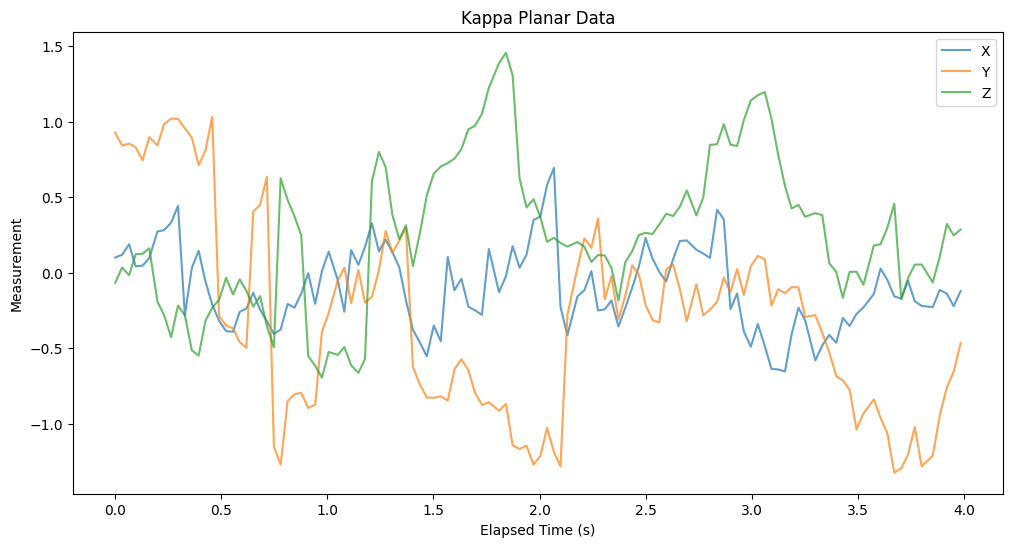

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(dev['Elapsed'], dev['X'], label='X', alpha=0.7)
plt.plot(dev['Elapsed'], dev['Y'], label='Y', alpha=0.7)
plt.plot(dev['Elapsed'], dev['Z'], label='Z', alpha=0.7)
plt.title(devname + ' ' + (imutype[0].upper() + imutype[1:]) + ' Data')
plt.xlabel('Elapsed Time (s)')
plt.ylabel('Measurement')
plt.legend()
plt.show()

Copyright © 2025 Callum Mackenzie